# Algoritmo Genético

Algoritmo genético aplicado a um problema geofísico para estimar o raio e o topo de um prisma de base poligonal próximo de um cilindro.

# Importando pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
import cPickle as pickle
from visual import histeq
from fatiando import utils
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.gridder import regular

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


# Função geofísica

In [2]:
def geofisica(xp, yp, zp, p, M, dz, props, dobs, inc, dec):
    '''
    This function calculates the data for polygonal
    prisms of the Fatiando a Terra with the two given parameters.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    p: 1D array - parameter vector
    M: int - number of vertices
    L: int - number of prisms
    dz: float - thickness of each prism
    props: dictionary - physical property
    dobs: 1D array - observed data
    inc: float - inclination
    dec: declination

    output

    prism: list - list of objects of the class fatiando.mesher.PolygonalPrism
    d: 1D array - data vector
    res: 1D array - residual data
    phi: float - misfit function value
    '''
    
    r = np.zeros(M) + p[0] # radial distance for each vertice

    # Cartesian coordinates of the origin of each prism
    x0 = 0. 
    y0 = 0.

    l = [r, x0, y0, p[1], p[1] + dz, props]   # list of parameters of the prisms
    
    ang = 2*np.pi/M # angle between two vertices
    
    prism = []
    verts=[]
    for i in range(M):
        verts.append([r[i]*np.cos(i*ang) + l[1], r[i]*np.sin(i*ang) + l[2]])
    prism.append(PolygonalPrism(verts, l[3], l[4], l[5]))
    
    d = polyprism.tf(xp, yp, zp, prism, inc, dec)
    res = dobs - d
    phi = np.dot(res, res)
    
    return prism, d, res, phi

# Modelagem direta

In [3]:
M = 10 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters

z0_true = 100.    # depth of the top the shallowest prism
dz = 500.    # thickness of each prism

inc = -60.  # inclination
dec = 50.   # declination
intensity = 0.035 # intensity

props={'magnetization': utils.ang2vec(intensity, inc, dec)} # physical property: magnetization

r_true = 500.

r = np.zeros(M) + r_true # radial distance for each vertice

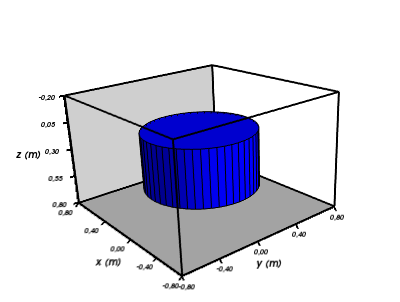

In [4]:
img(filename='bolacha.png')

# Pontos de observação

In [5]:
area = [-2000, 2000, -2000, 2000] #x minimum, x maximum, y minimum and y maximum
shape = (50,50) #number of data along the y and x directions
N = shape[0]*shape[1] #total number of data

#coordinates x and y of the data
xp, yp = regular(area, shape)

zp = np.zeros(N) - 100.

# Dados observados

In [6]:
p_true = np.array([r_true, z0_true])
prism_true, data, res_, phi_true = geofisica(xp, yp, zp, p_true, M, dz, props, np.zeros(xp.size), inc, dec)
amp_noise = 0.01*np.max(data)
data_noise = data + np.random.normal(loc=0., scale=amp_noise, size=shape[0]*shape[1]) # noise corrupted data

# Plot função desajuste

In [7]:
shape2 = (15,15)
r_plot = np.linspace(10., 1000., shape2[0])
z0_plot = np.linspace(-100., 500., shape2[1])
r_plot,z0_plot = np.meshgrid(r_plot, z0_plot)
r_plot = r_plot.ravel()
z0_plot = z0_plot.ravel()
phi_plot = np.zeros_like(r_plot)

for i, (r, z) in enumerate(zip(r_plot,z0_plot)):
    p = np.array([r, z])
    prism_pred, d_pred, res, phi_plot[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)

r_plot = r_plot.reshape(shape2)
z0_plot = z0_plot.reshape(shape2)
phi_plot = phi_plot.reshape(shape2)

# equalizando as cores
phi_eq = histeq(phi_plot)
phi_eq = np.reshape(phi_eq,shape2)
phi_eq = phi_eq

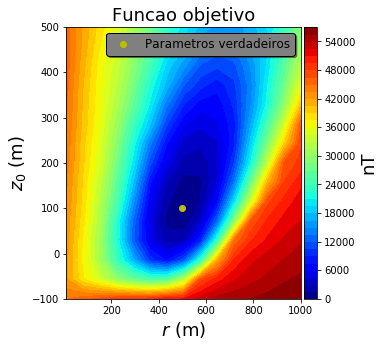

In [8]:
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'oy', label='Parametros verdadeiros')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).set_label('nT', fontsize=18)
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, facecolor='gray', edgecolor='black')
plt.show()

# Funções auxiliares para o algoritmo genético

In [9]:
def populacao(G, n, l, h):
    '''
    Cria uma população.
    
    input:
    G - número de gens
    n - integer - número de indivíduos
    l - 1D array - valores mínimos para os parâmetros
    h - 1D array - valores máximos para os parâmetros
    
    output:
    pop - 2D array - população
    '''
    pop = np.zeros((n, G))
    
    for i in range(G):
        pop[:, i] = np.random.uniform(low=l[i], high=h[i], size=n)
    
    return pop

In [10]:
def aptidao(f):
    '''
    Esta função calcula a aptidão de uma população
    através do vetor que possui o valor da função
    objeto para cada indivíduo.
    
    input:
    f - 1D array - valores da função para cada indivíduo
    
    output:
    s - 1D array - aptidão de cada indivíduo 
    '''
    s = 1./(1. + abs(f))
    s /= np.sum(s)
    
    return s

In [11]:
def cruzamento(n, G, pop, s):
    '''
    Esta função seleciona os indivíduos pais, faz o cruzamento
    e gera uma população de filhos.
    
    input:
    n - integer - número de indivíduos
    G - integer - número de gens
    pop - 2D array (n,M) - população (cada linha representa um indivíduo)
    s - 1D array - aptidão para cada da população
    
    output:
    popf - 2D array - população de filhos 
    '''
    # selecionando pais e maes para o cruzamento
    i_pai = []
    i_mae = []
    for i in range(n):
        i1, i2 = np.random.choice(np.arange(n), size=G, replace=False, p=s)
        i_pai.append(i1)
        i_mae.append(i2)
    
    # cruzamento
    popf = np.zeros_like(pop)
    popf[:, 0] = (pop[i_pai, 0]*s[i_pai] + pop[i_mae, 0]*s[i_mae])/(s[i_pai] + s[i_mae])
    popf[:, 1] = (pop[i_pai, 1]*s[i_pai] + pop[i_mae, 1]*s[i_mae])/(s[i_pai] + s[i_mae])
    
    return popf

In [12]:
def mutacao(n, G, pop, prob, l, h):
    '''
    Esta função seleciona aleatoriamente
    um gen e aplica uma mutação sobre ele.
    
    input:
    n - integer - número de indivíduos
    G - integer - número de gens
    pop - 2D array (n,M) - população (cada linha representa um indivíduo)
    prob - float - probabilidade de haver mutação
    l - 1D array - valores mínimos para os parâmetros
    h - 1D array - valores máximos para os parâmetros
    
    output:
    pop - 2D array - população (pode ou não ter sofrido mutação)
    '''
    # mutação
    prob = 0.1
    for i in range(n):
        rand = np.random.rand()
        if rand <= prob:
            i_mut = np.random.choice(np.arange(G))
            pop[i,i_mut] *= (np.random.uniform(low=l[i_mut], high=h[i_mut], size=None)/(h[i_mut] - l[i_mut]))
            #print 'sofreu mutação', i, i_mut, pop[i, i_mut]
    
    return pop

In [13]:
def elitismo(n, popp, popf, fp, ff, sp, sf, resp, resf):
    '''
    Esta seleciona aleatoriamente um gen e aplica uma mutação sobre ele.
    
    input:
    n - integer - número de indivíduos
    popp - 2D array (n,M) - população de pais (cada linha representa um indivíduo)
    popf - 2D array (n,M) - população de filhos (cada linha representa um indivíduo)
    fp - 1D array - valores da função para cada pai
    ff - 1D array - valores da função para cada filho
    sp - 1D array - aptidão para cada pai
    sf - 1D array aptidão para cada filho
    resp - 2D array - resíduo para cada pai
    resf - 2D array - resíduo para cada filho
    
    output:
    popn - 2D array - população nova
    '''
    
    nr = n/20 # número de filhos replicados
    
    # juntando pais com filhos
    popt = np.vstack((popp, popf))
    ft = np.hstack((fp, ff))
    rest = np.vstack((resp, resf))
    
    # ordenando e escolhendo os melhores
    i_ord = np.argsort(ft)
    popn = popt[i_ord[:n],:]
    fn = ft[i_ord[:n]]
    resn = rest[i_ord[:n]]
    
    # replicando os melhores filhos
    if nr >= 1:
        popn[-nr:,:] = popn[:nr,:]
        fn[-nr:] = fn[:nr]
        resn[-nr:] = resn[:nr]
    
    sn = sn = aptidao(fn)
    
    return popn, fn, sn, resn

# Chute inicial

In [14]:
# número de gens
G = 2

# número de indivíduos
n = 50

# valores máximos e mínimos dos parâmetros
rmax = 950.
rmin = 50.
z0max = 550.
z0min = 10.

# vetores com os valores limites
l = np.array([rmin, z0min])
h = np.array([rmax, z0max])

# criando a população
pop0 = populacao(G, n, l, h)

In [15]:
# avaliando a função para a população inicial
prism0 = []
d0 = np.zeros((n,shape[0]*shape[1]))
res0 = np.zeros((n,shape[0]*shape[1]))
phi0 = np.zeros(n)

for i, p in enumerate(pop0):
    prism, d0[i], res0[i], phi0[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)
    prism0.append(prism)

In [16]:
# calculando a aptidão
s0 = aptidao(phi0)

In [17]:
# selecionando o melhor indivíduo do chute inicial
i_melhor = np.argmax(s0)

# armazenando o melhor indivíduo do chute inicial
p1_list = [pop0[i_melhor,0]]
p2_list = [pop0[i_melhor,1]]
phi_list = [phi0[i_melhor]]

# número de iterações máximo
itmax = 60

# tolerância
tol = 1e-5

# Algoritmo genético

In [18]:
for it in range(itmax):
    # cruzamento
    popf = cruzamento(n, G, pop0, s0)
    
    # mutação
    popf = mutacao(n, G, popf, 0.1, l, h)

    # avaliando a função para os filhos
    prism = []
    d = np.zeros((n,shape[0]*shape[1]))
    res = np.zeros((n,shape[0]*shape[1]))
    phi = np.zeros(n)

    for i, p in enumerate(popf):
        prism, d[i], res[i], phi[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)
        prism0.append(prism)

    # calculando a aptidão dos filhos
    s = aptidao(phi)

    # elitismo
    popn, phin, sn, resn = elitismo(n, pop0, popf, phi0, phi, s0, s, res0, res)
          
    # selecionando o melhor indivíduo da população
    i_melhor = np.argmax(sn)

    # armazenando o melhor indivíduo da população
    p1_list.append(popn[i_melhor,0])
    p2_list.append(popn[i_melhor,1])
    phi_list.append(phin[i_melhor])
    res2plot = resn[i_melhor]
    
    print 'iteração: %3d   r: %.2f   z0: %.2f   s: %.2e    f: %.2e' % (it, popn[i_melhor,0], popn[i_melhor,1], sn[i_melhor], phin[i_melhor])
    
    # atualiza as variáveis
    pop0 = popn.copy()
    phi0 = phin.copy()
    s0 = sn.copy()
    res0 = resn.copy()

iteração:   0   r: 524.24   z0: 144.01   s: 5.73e-02    f: 9.40e+01
iteração:   1   r: 498.37   z0: 131.48   s: 3.44e-02    f: 7.51e+01
iteração:   2   r: 517.77   z0: 134.42   s: 2.86e-02    f: 6.75e+01
iteração:   3   r: 508.36   z0: 87.71   s: 3.57e-02    f: 4.10e+01
iteração:   4   r: 504.81   z0: 103.28   s: 4.40e-02    f: 2.19e+01
iteração:   5   r: 504.81   z0: 103.28   s: 2.66e-02    f: 2.19e+01
iteração:   6   r: 504.81   z0: 103.28   s: 2.24e-02    f: 2.19e+01
iteração:   7   r: 504.81   z0: 103.28   s: 2.12e-02    f: 2.19e+01
iteração:   8   r: 504.81   z0: 103.28   s: 2.06e-02    f: 2.19e+01
iteração:   9   r: 504.81   z0: 103.28   s: 2.03e-02    f: 2.19e+01
iteração:  10   r: 504.81   z0: 103.28   s: 2.01e-02    f: 2.19e+01
iteração:  11   r: 504.81   z0: 103.28   s: 2.00e-02    f: 2.19e+01
iteração:  12   r: 504.85   z0: 103.12   s: 2.00e-02    f: 2.19e+01
iteração:  13   r: 504.85   z0: 103.12   s: 2.00e-02    f: 2.19e+01
iteração:  14   r: 504.84   z0: 103.16   s: 2.00e

# Plots de resultados

In [19]:
res_norm = (res2plot - np.mean(res2plot))/np.std(res2plot)
res_plot = res2plot.reshape(shape)
dpred = data.reshape(shape)
dobs = data_noise.reshape(shape)

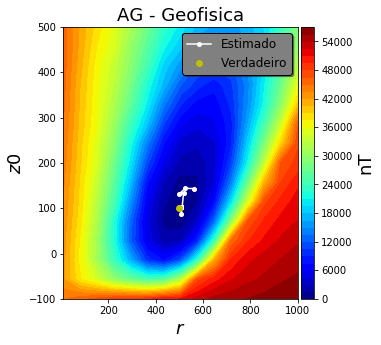

In [20]:
#plot
plt.figure(figsize=(5,5))
plt.plot(p1_list, p2_list, '.w-', markersize=8, label='Estimado')
plt.plot(r_true, z0_true, 'oy', label='Verdadeiro')
plt.title('AG - Geofisica', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet')
plt.xlabel('$r$', fontsize=18)
plt.ylabel('$z0$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).set_label('nT', fontsize=18)
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, facecolor='gray', edgecolor='black')
plt.show()

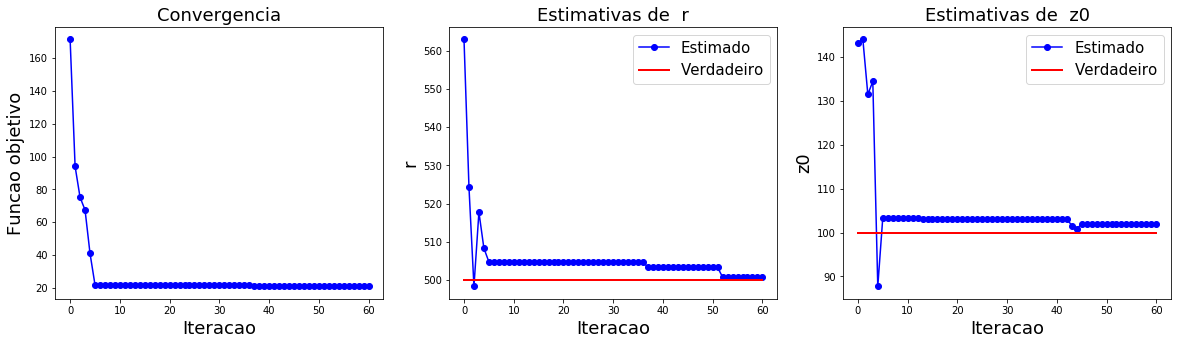

In [23]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Convergencia', fontsize = 18)
plt.ylabel('Funcao objetivo', fontsize = 18)
plt.xlabel('Iteracao', fontsize = 18)
plt.plot(phi_list, 'bo-', label='Estimado')

plt.subplot(1, 3, 2)
plt.title('Estimativas de  r', fontsize = 18)
plt.xlabel('Iteracao', fontsize = 18)
plt.ylabel('r', fontsize = 18)
plt.plot(p1_list, 'bo-', label='Estimado')
plt.plot(np.zeros(len(p1_list)) + r_true, 'r-', linewidth=2, label='Verdadeiro')
plt.legend(loc=0, fontsize=15)

plt.subplot(1, 3, 3)
plt.title('Estimativas de  z0', fontsize = 18)
plt.xlabel('Iteracao', fontsize = 18)
plt.ylabel('z0', fontsize = 18)
plt.plot(p2_list, 'bo-', label='Estimado')
plt.plot(np.zeros(len(p1_list)) + z0_true, 'r-', linewidth=2, label='Verdadeiro')
plt.legend(loc=0, fontsize=15)
plt.show()

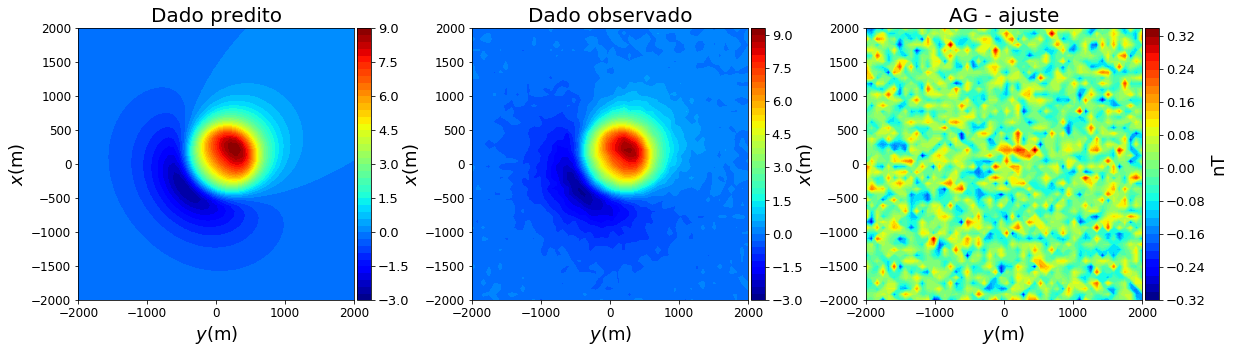

In [24]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dpred, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 3)
plt.title('AG - ajuste', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), res_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.set_label('nT', fontsize=18)
clb.ax.tick_params(labelsize=13)
plt.show()

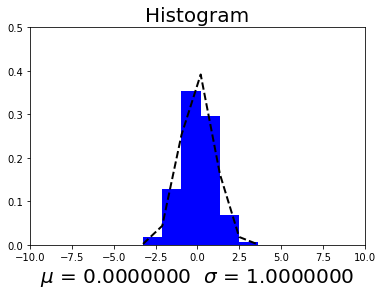

In [25]:
plt.plot(figsize=(30,25))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
n, bins, patches = plt.hist(res_norm,bins=nbins, normed=True, color='blue')
gauss = normpdf(bins, np.mean(res_norm), np.std(res_norm))
plt.plot(bins, gauss, 'k--', linewidth=2.)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.show()